In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import os
import sklearn.preprocessing
#type artefacts
from typing import Tuple, List, Union
from pandas import DataFrame

#min-max scaler
scaler = sklearn.preprocessing.MinMaxScaler()

In [2]:
#interested in x, y, z and anomaly label
FEATURES = ["X (m/s^2)", "Y (m/s^2)", "Z (m/s^2)", "Anamoly"]

def get_file_list_from_directory(directory_path: str) -> List[str]:
    """
    Returns a List of filename paths
        :param directory_path: string of a path to recursively search through
        :return: List (filename_paths)
    """
    
    datasets = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            if file.find('.xlsx') != -1:
                datasets.append(os.path.join(subdir, file))
    
    return datasets

def get_frames_from_file_list(filelist: List[str], columns: Union[List[int], None], seperator: str = ",") -> List[DataFrame]:
    """
    This method return a list of DataDrames and evtually stores it as pickle file
        :param filelist: List(paths)
        :param columns: List(indices)
        :param name: filename to be, if None the dataframes will not be stored
        :param seperator: ; or ,
        :return;
    """
    
    dataframes = []
    scaler = sklearn.preprocessing.MinMaxScaler()
    for i in range(len(filelist)):
        if not columns:
            series = pd.read_excel(filelist[i], header = 0)
            #comment line below to get first column as a feature
            series = series.drop(series.column[0], axis=1)
        
        else:
            #read from column list input
            series = pd.read_excel(filelist[i], usecols=columns, header=0)
        dataframes.append(series)
        
    #fit features for all dataframes
    dataframes = fit_min_max_frames(dataframes)
    return dataframes

def fit_min_max_frames(frames: List[DataFrame]) -> List[DataFrame]:
    """
    Performs a Min/Max Scaling on a List of DataFrames (between 0, 1)
        :param frames: List(pandas.DataFrame)
        :return: List(pandas.DataFrame)
    """
    
    for i, frame in enumerate(frames):
        for column in frame:
            if frame[column].dtype == np.float64 or frame[column].dtype == np.int64:
                scaler.fit(np.array(frame[column]).reshape(-1, 1))
                frame[column] = scaler.fit_transform(frame[[column]])

    return frames

def get_basic_info_from_frames(frames: List[DataFrame]) -> int:
    """
    Get the sum of all samples in the list of dataframes
        :param frames: List(pandas.DataFrame)
        :return: int
    """
    
    sum = 0
    anomalies = 0
    normal = 0
    for frames in frames:
        sum += len(frames)
        anomalies += frames.Anamoly.value_counts()
        normal += frames.Anamoly.value_counts()[0]
    
    return sum, anomalies, normal

def join_frames_from_list(frames: List[DataFrame]) -> DataFrame:
    """
    Joins a list of dataframes by appending them
        :param frames: List(pandas.DataFrame)
        :return: pandas.DataFrame
    """
    
    result = pd.concat(frames)
    assert result is not None
    return result

def train_model(model, model_name):
    """
    Model Training cycle requires sklearn Model as input
        :param model: sklearn.Model
        :param model)name: str
        :return: str
    """
    
    print(model_name)
    accuracy = {}
    
    #Fitting model
    model = model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    #Model accuracy
    acc = accuracy_score(y_test, pred)*100
    accuracy[model_name] = acc
    print('accuracy_score', acc)
    print()
    
    #Classification Report
    print('Classification Report')
    print(classification_report(y_test, pred))
    return "Done"       


In [3]:
#Load the file paths
train_paths = get_file_list_from_directory('/Users/ayaan/Desktop/Fall Detection/Fall Detection 2/Fall Detection Acc/Train')
test_paths = get_file_list_from_directory('/Users/ayaan/Desktop/Fall Detection/Fall Detection 2/Fall Detection Acc/Test')

#Load the data in pandas
train_frames = get_frames_from_file_list(train_paths, columns=FEATURES)
test_frames = get_frames_from_file_list(train_paths, columns=FEATURES)

In [4]:
#basic info
train_count, train_anomaly_count, train_normal_count = get_basic_info_from_frames(train_frames)
test_count, test_anomaly_count, test_normal_count = get_basic_info_from_frames(test_frames)

#distribution info
train_normal_dist = round((train_count - train_anomaly_count) / train_count, 3)
test_normal_dist = round((test_count - test_anomaly_count) / test_count, 3)
train_anomaly_dist = round(train_anomaly_count / train_count, 3)
test_anomaly_dist = round(test_anomaly_count / test_count, 3)

#output info
print(f"\n training samples => \n\t overall: {train_count}, \n\t normal: {train_normal_count}, \n\t anomalous: {train_anomaly_count}")
print(f"\n training distribution => \n\t overall: {train_normal_dist}, \n\t normal: {train_anomaly_dist}")
print(f"\n testing samples => \n\t overall: {test_count}, \n\t normal: {test_normal_count}, \n\t anomalous: {test_anomaly_count}")
print(f"\n testing distribution => \n\t overall: {test_normal_dist}, \n\t normal: {test_anomaly_dist}")


 training samples => 
	 overall: 503, 
	 normal: 67, 
	 anomalous: 1.0    436
0.0     67
Name: Anamoly, dtype: int64

 training distribution => 
	 overall: 1.0    0.133
0.0    0.867
Name: Anamoly, dtype: float64, 
	 normal: 1.0    0.867
0.0    0.133
Name: Anamoly, dtype: float64

 testing samples => 
	 overall: 503, 
	 normal: 67, 
	 anomalous: 1.0    436
0.0     67
Name: Anamoly, dtype: int64

 testing distribution => 
	 overall: 1.0    0.133
0.0    0.867
Name: Anamoly, dtype: float64, 
	 normal: 1.0    0.867
0.0    0.133
Name: Anamoly, dtype: float64


In [5]:
#get the first (or nth) frame
train_example = train_frames[18]
test_example = test_frames[19]

#output info
print("TRAINING\n")
print(train_example.info())
print(train_example.describe())
print("TESTING\n")
print(test_example.info())
print(test_example.describe())

TRAINING

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X (m/s^2)  10 non-null     float64
 1   Y (m/s^2)  10 non-null     float64
 2   Z (m/s^2)  10 non-null     float64
 3   Anamoly    10 non-null     float64
dtypes: float64(4)
memory usage: 448.0 bytes
None
       X (m/s^2)  Y (m/s^2)  Z (m/s^2)    Anamoly
count  10.000000  10.000000  10.000000  10.000000
mean    0.462812   0.642511   0.850541   0.900000
std     0.246310   0.253971   0.314334   0.316228
min     0.000000   0.000000   0.000000   0.000000
25%     0.436876   0.673097   0.952390   1.000000
50%     0.487498   0.690187   0.979021   1.000000
75%     0.492629   0.707660   0.985097   1.000000
max     1.000000   1.000000   1.000000   1.000000
TESTING

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  

In [6]:
#visualization, configure seaborn
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_theme()
sns.set_style("dark")

Text(0.5, 1.0, 'Training Example Frame')

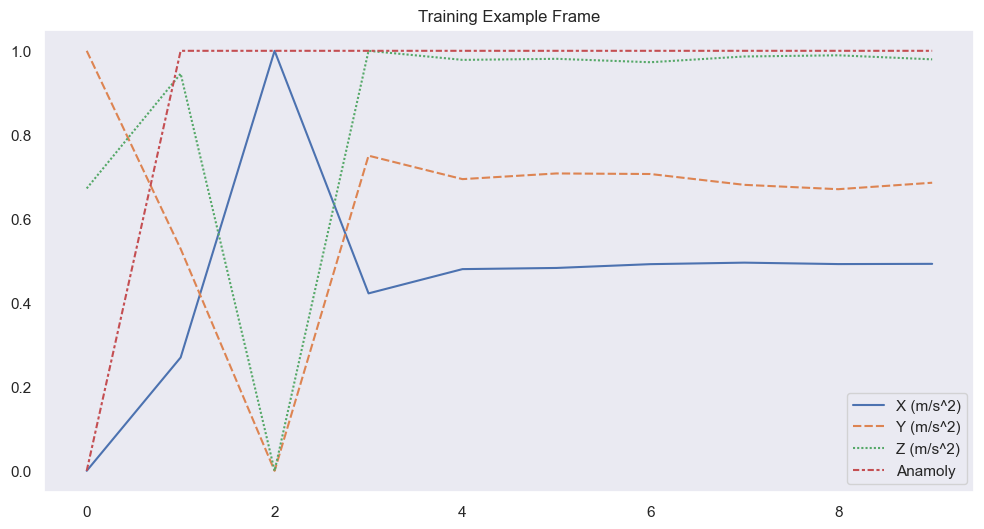

In [7]:
sns.lineplot(data=train_example).set_title('Training Example Frame')

Text(0.5, 1.0, 'Testing Example Frame')

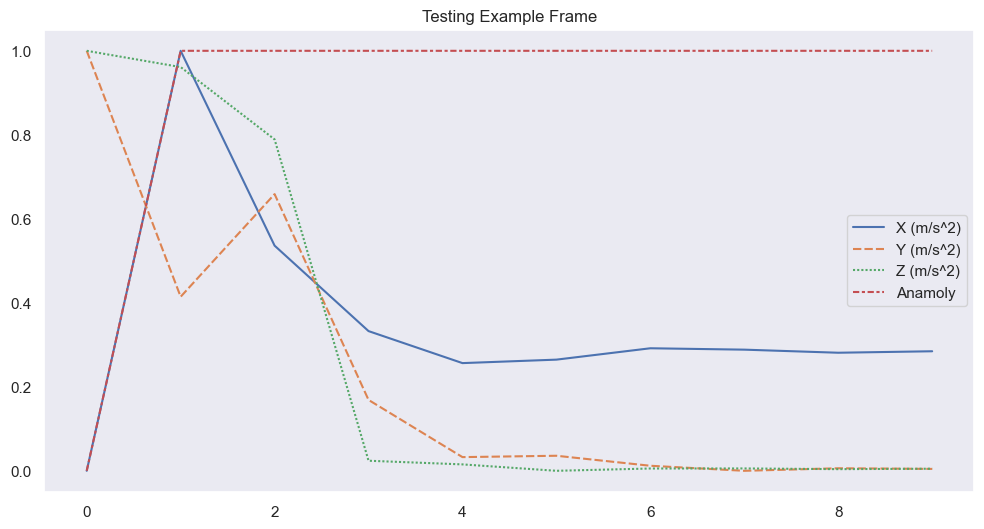

In [8]:
sns.lineplot(data=test_example).set_title('Testing Example Frame')

In [9]:
train = join_frames_from_list(train_frames)
test = join_frames_from_list(test_frames)
print("Training shape: ", train.shape)
print("Testing shape: ", test.shape)

Training shape:  (503, 4)
Testing shape:  (503, 4)


In [10]:
#Importing Machine Leaning Model
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

#statistical Tools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [11]:
x_train = train.drop(columns=["Anamoly"], axis=1)
y_train = train["Anamoly"]
x_test = test.drop(columns=["Anamoly"], axis=1)
y_test = test["Anamoly"]

In [12]:
cat = CatBoostClassifier(verbose = 1, n_estimators = 1000)
train_model(cat, "Cat Boost")

Cat Boost
Learning rate set to 0.007683
0:	learn: 0.6862248	total: 54.1ms	remaining: 54s
1:	learn: 0.6778448	total: 55.7ms	remaining: 27.8s
2:	learn: 0.6697468	total: 57.2ms	remaining: 19s
3:	learn: 0.6633931	total: 59.1ms	remaining: 14.7s
4:	learn: 0.6560719	total: 60.6ms	remaining: 12.1s
5:	learn: 0.6480402	total: 61.9ms	remaining: 10.3s
6:	learn: 0.6408590	total: 63.3ms	remaining: 8.98s
7:	learn: 0.6334424	total: 64.8ms	remaining: 8.03s
8:	learn: 0.6250635	total: 65.8ms	remaining: 7.25s
9:	learn: 0.6184951	total: 66.8ms	remaining: 6.61s
10:	learn: 0.6113532	total: 67.7ms	remaining: 6.09s
11:	learn: 0.6040623	total: 68.9ms	remaining: 5.67s
12:	learn: 0.5965926	total: 70.1ms	remaining: 5.32s
13:	learn: 0.5909045	total: 71.1ms	remaining: 5.01s
14:	learn: 0.5845035	total: 72.1ms	remaining: 4.74s
15:	learn: 0.5786465	total: 73.1ms	remaining: 4.5s
16:	learn: 0.5723038	total: 74.1ms	remaining: 4.29s
17:	learn: 0.5666541	total: 75.1ms	remaining: 4.09s
18:	learn: 0.5606694	total: 75.9ms	rema

384:	learn: 0.1700657	total: 371ms	remaining: 593ms
385:	learn: 0.1698196	total: 372ms	remaining: 592ms
386:	learn: 0.1696521	total: 373ms	remaining: 591ms
387:	learn: 0.1693887	total: 374ms	remaining: 590ms
388:	learn: 0.1692390	total: 375ms	remaining: 588ms
389:	learn: 0.1690102	total: 375ms	remaining: 587ms
390:	learn: 0.1689112	total: 376ms	remaining: 586ms
391:	learn: 0.1688295	total: 377ms	remaining: 585ms
392:	learn: 0.1685873	total: 378ms	remaining: 584ms
393:	learn: 0.1683948	total: 379ms	remaining: 582ms
394:	learn: 0.1681127	total: 379ms	remaining: 581ms
395:	learn: 0.1678752	total: 380ms	remaining: 580ms
396:	learn: 0.1676463	total: 381ms	remaining: 579ms
397:	learn: 0.1674050	total: 382ms	remaining: 578ms
398:	learn: 0.1672728	total: 383ms	remaining: 576ms
399:	learn: 0.1670632	total: 383ms	remaining: 575ms
400:	learn: 0.1668871	total: 384ms	remaining: 574ms
401:	learn: 0.1666903	total: 385ms	remaining: 573ms
402:	learn: 0.1664009	total: 386ms	remaining: 571ms
403:	learn: 

628:	learn: 0.1300369	total: 554ms	remaining: 327ms
629:	learn: 0.1299289	total: 555ms	remaining: 326ms
630:	learn: 0.1297629	total: 556ms	remaining: 325ms
631:	learn: 0.1296341	total: 557ms	remaining: 324ms
632:	learn: 0.1295409	total: 558ms	remaining: 323ms
633:	learn: 0.1294480	total: 558ms	remaining: 322ms
634:	learn: 0.1293668	total: 559ms	remaining: 321ms
635:	learn: 0.1292875	total: 560ms	remaining: 320ms
636:	learn: 0.1291621	total: 561ms	remaining: 319ms
637:	learn: 0.1290390	total: 561ms	remaining: 319ms
638:	learn: 0.1288718	total: 562ms	remaining: 318ms
639:	learn: 0.1287358	total: 563ms	remaining: 317ms
640:	learn: 0.1286019	total: 564ms	remaining: 316ms
641:	learn: 0.1284951	total: 565ms	remaining: 315ms
642:	learn: 0.1284070	total: 565ms	remaining: 314ms
643:	learn: 0.1282303	total: 566ms	remaining: 313ms
644:	learn: 0.1281409	total: 567ms	remaining: 312ms
645:	learn: 0.1280457	total: 568ms	remaining: 311ms
646:	learn: 0.1279242	total: 569ms	remaining: 310ms
647:	learn: 

874:	learn: 0.1029858	total: 738ms	remaining: 105ms
875:	learn: 0.1028774	total: 739ms	remaining: 105ms
876:	learn: 0.1027963	total: 740ms	remaining: 104ms
877:	learn: 0.1026555	total: 741ms	remaining: 103ms
878:	learn: 0.1025597	total: 742ms	remaining: 102ms
879:	learn: 0.1024959	total: 742ms	remaining: 101ms
880:	learn: 0.1023854	total: 743ms	remaining: 100ms
881:	learn: 0.1023276	total: 744ms	remaining: 99.5ms
882:	learn: 0.1022521	total: 745ms	remaining: 98.7ms
883:	learn: 0.1021623	total: 746ms	remaining: 97.8ms
884:	learn: 0.1021028	total: 746ms	remaining: 97ms
885:	learn: 0.1020256	total: 747ms	remaining: 96.1ms
886:	learn: 0.1019680	total: 748ms	remaining: 95.3ms
887:	learn: 0.1018820	total: 749ms	remaining: 94.4ms
888:	learn: 0.1017931	total: 750ms	remaining: 93.6ms
889:	learn: 0.1017109	total: 750ms	remaining: 92.7ms
890:	learn: 0.1015864	total: 751ms	remaining: 91.9ms
891:	learn: 0.1015043	total: 752ms	remaining: 91ms
892:	learn: 0.1014074	total: 753ms	remaining: 90.2ms
893:

'Done'

In [13]:
rfc = RandomForestClassifier(n_estimators = 1500, n_jobs = -1, max_depth = 15, min_samples_split = 5, min_samples_leaf = 3)
train_model(rfc, 'Random Forest Classifier')

Random Forest Classifier
accuracy_score 94.43339960238568

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.64      0.75        67
         1.0       0.95      0.99      0.97       436

    accuracy                           0.94       503
   macro avg       0.93      0.82      0.86       503
weighted avg       0.94      0.94      0.94       503



'Done'

In [14]:
xgb = XGBClassifier(n_estimators = 1500, nthread = 4, max_depth = 15, min_child_weight = 5, learning_rate = 0.01)
train_model(xgb, 'XGBClassifier')

XGBClassifier
accuracy_score 94.63220675944333

Classification Report
              precision    recall  f1-score   support

         0.0       0.92      0.66      0.77        67
         1.0       0.95      0.99      0.97       436

    accuracy                           0.95       503
   macro avg       0.93      0.82      0.87       503
weighted avg       0.95      0.95      0.94       503



'Done'

In [15]:
import pickle

In [17]:
saved_model = pickle.dump(xgb, open('model.pkl', 'wb'))